## **Importing Necessary libraries**

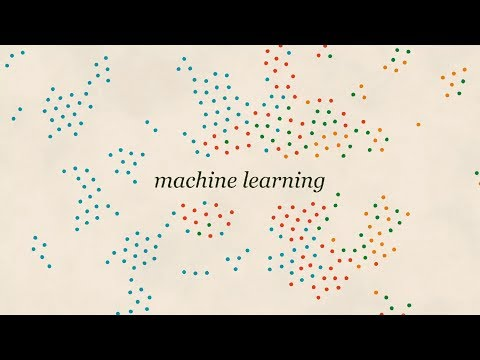

In [6]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [7]:
import IPython
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
import  numpy as np
from tqdm import tqdm

I have used 3 datasets.
1. One dataset which has celebrity faces -> CelebA: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
2. One dataset which has non faces -> ImageNet : https://image-net.org/
3. One dataset for Test Cases

In [8]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [9]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

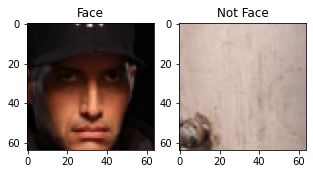

In [10]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 15
idx_not_face = 36 

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

# **Method 1 : Standard CNN**
This is method has series of **Convolutional layers** followed by **BatchNormalization** then **Flattening** the feature map obtained to a single vector feed for **2 Fully Connected Neural Network** getting the probability of each distribution and mapping it to specific class.

In [11]:
n_filters = 12

def make_standard_classifier(n_outputs = 1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding = 'same', activation = 'relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense , activation = 'relu')
  model = tf.keras.Sequential([
                               Conv2D(filters = n_filters, kernel_size = 5, strides = 2),
                               BatchNormalization(),

                               Conv2D(filters = 2*n_filters, kernel_size = 5, strides = 2),
                               BatchNormalization(),

                               Conv2D(filters = 4*n_filters, kernel_size = 3, strides = 2),
                               BatchNormalization(),

                               Conv2D(filters = 6*n_filters, kernel_size = 3, strides = 2),
                               BatchNormalization(),

                               Flatten(),
                               Dense(512),
                               Dense(n_outputs, activation = None),
             
  ])
  
  return model
standard_classifier = make_standard_classifier()

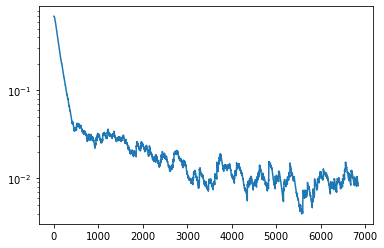

100%|██████████| 3434/3434 [04:18<00:00, 13.29it/s]


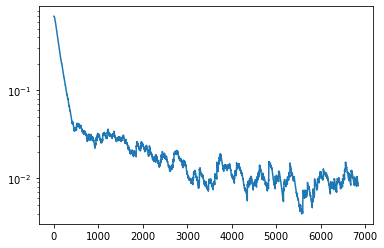

In [12]:
batch_size = 32
num_epochs = 2
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec = 2, scale = 'semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x,y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits)
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x,y)
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [13]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Accuracy : ", acc_standard.numpy())

Accuracy :  0.9974


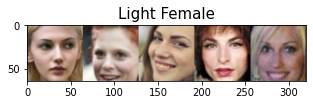

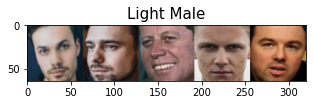

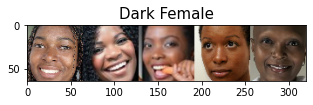

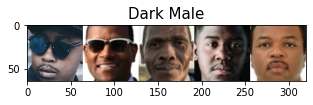

In [14]:
test_faces = mdl.lab2.get_test_faces()
keys = ['Light Female', 'Light Male', 'Dark Female', 'Dark Male']
for group, key in zip(test_faces, keys):
  plt.figure(figsize = (5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize = 15)
  

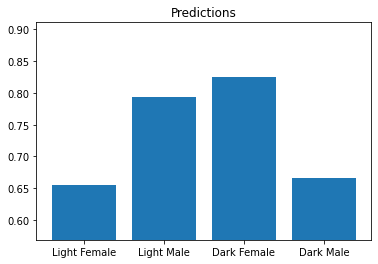

In [15]:
logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
probs = tf.squeeze(tf.sigmoid(logits))
x = range(len(keys))
y = probs.numpy().mean(1)
plt.bar(x, y)
plt.xticks(x, keys)
plt.ylim(max(0,y.min()-y.ptp()/2.), y.max()+y.ptp()/2.)
plt.title("Predictions");

Now as we can see the predictions we see that the prediction distribution for each class is not high and this is because there are cases when the training dataset might be biased.

Say the CelebA has dataset which has higher distribution of light female. So clearly the accuracy for light people would be better than dark [ No Racism just for example ]

So We move towards another approach that is widely used now-a-days.

#**Method 2 : Debiasing Variational Auto-Encoder [DB-VAE]** 
The approach is that the model should be able to learn the data in unsupervised way that it should predict all the underlying latent features.

Now by using the DB-VAE I try to resample the entire training dataset that we provide to encoder such that we give importance to rarer images like dark skin, glasses etc.

As this is VAE we know that it doesn't predict any classes. However we try to output the mean and sigma values of each image feature that we obtain and use that for backproprogation. 

In [16]:
def vae_loss_function(x,x_recon, mu,logsigma,kl_weight = 0.005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.pow(mu, 2) -1 - logsigma,axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss


In [4]:
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 27.7 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=c59edb4892b9b2131d04466c9d94f9d12cf60294eed1a87fd1019868ecce7e52
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [17]:
def sampling(z_mean, z_logsigma):
  batch , latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape = (batch ,latent_dim))
  z = z_mean + tf.exp(0.5*z_logsigma) * epsilon
  return z

In [18]:
def debiasing_loss_function(x,x_pred,y,y_logit,mu,logsigma):
  vae_loss = vae_loss_function(x,x_pred,mu,logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = y_logit)
  face_indicator = tf.cast(tf.equal(y,1), tf.float32)
  print(face_indicator)
  total_loss = classification_loss + face_indicator * vae_loss
  return total_loss,classification_loss

## **DB-VAE Architecture**
Since VAE has encoder and decoder we use the encoder from CNN above and construct a decoder network and combine these two into one.

**Decoder :**
We apply deconvolution layers using Conv2DTranspose and try to reconstruct a image from input

In [19]:
n_filters = 12
latent_dim = 100
def make_face_decoder_network():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose,padding = 'same',activation = 'relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense,activation = 'relu')
  Reshape = tf.keras.layers.Reshape
  decoder = tf.keras.Sequential([
                                 Dense(units = 4*4*6*n_filters),
                                 Reshape(target_shape = (4,4,6*n_filters)),
                                 Conv2DTranspose(filters = 4*n_filters, kernel_size = 3, strides = 2),
                                 Conv2DTranspose(filters = 2*n_filters, kernel_size = 3, strides = 2),
                                 Conv2DTranspose(filters = 1*n_filters, kernel_size = 5, strides = 2),
                                 Conv2DTranspose(filters = 3, kernel_size = 5, strides =2),
  ])
  return decoder

## Subclassing the Encoder and Decoder inside the class by inheriting the Model class.

In [20]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim
    num_encoders_dims = 2 * self.latent_dim + 1
    self.encoder = make_standard_classifier(num_encoders_dims)
    self.decoder = make_face_decoder_network()
  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:,0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]
    return y_logit , z_mean, z_logsigma
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean,z_logsigma)
    return z
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction
  def call(self, x):
    y_logit, z_mean , z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit , z_mean, z_logsigma, recon
  def predict(self ,x):
    y_logit, z_mean ,z_logsigma = self.encode(x)
    return y_logit

dbvae  = DB_VAE(latent_dim)

In [21]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

This is the resampling algorithm which is most important because this tries to eliminate the biased dataset by feeding the part of training dataset which has occured the least.

In [22]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
  print("Sampling probabilities:")
  mu = get_latent_mu(images,dbvae)
  training_sample_p = np.zeros(mu.shape[0])
  for i in range(latent_dim):
    latent_distribution = mu[:,i]
    hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)
    bin_edges[0] = -float('inf')
    bin_edges[-1] = float('inf')
    bin_idx = np.digitize(latent_distribution , bin_edges)
    hist_smoothed_density = hist_density + smoothing_fac
    hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
    p = 1.0/(hist_smoothed_density[bin_idx-1])
    p = p/np.sum(p)
    training_sample_p = np.maximum(p,training_sample_p)
  training_sample_p /= np.sum(training_sample_p)
  return training_sample_p

## Training DB-VAE

Starting epoch 6/6
Sampling probabilities:


  0%|          | 0/3434 [00:00<?, ?it/s]

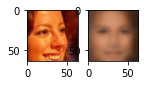

 15%|█▍        | 500/3434 [01:07<06:29,  7.54it/s]

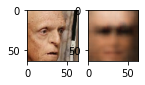

 29%|██▉       | 1000/3434 [02:15<05:33,  7.31it/s]

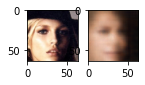

 44%|████▎     | 1500/3434 [03:23<04:21,  7.40it/s]

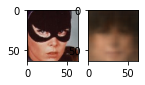

 58%|█████▊    | 2000/3434 [04:31<03:09,  7.57it/s]

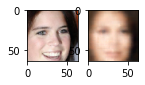

 73%|███████▎  | 2500/3434 [05:39<02:03,  7.54it/s]

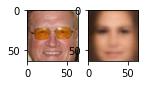

 87%|████████▋ | 3000/3434 [06:47<00:59,  7.34it/s]

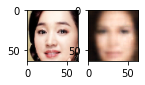

100%|██████████| 3434/3434 [07:46<00:00,  7.36it/s]


In [23]:
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

num_epochs = 6  
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae.call(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for i in range(num_epochs):
  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    loss = debiasing_train_step(x, y)
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

## **Comparing the probabilty distribution**
1. CNN
2. DB-VAE

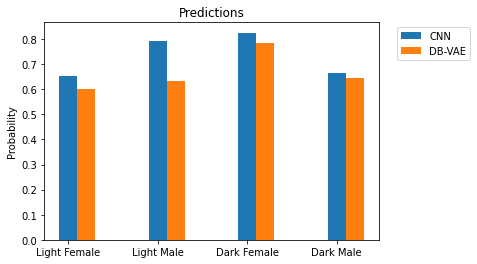

In [25]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, probs.numpy().mean(1), width=0.2, label="CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Predictions")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");